# Time Series Project

#### Meng Lin, Hannah Lyon, Kyrill Rekun, Qingyi Sun

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR

In [166]:
df = pd.read_csv('zillow-california.csv', squeeze=True)
df.columns = ['Date','Median_Sold_Price','Median_Mortgage','Unemployment','Median_Rental_Price']
df = df.drop(['Median_Rental_Price'], axis = 1)
df = df.reset_index()
df.drop(['Date'], axis=1, inplace=True)
df = df.dropna().reset_index()
df = df.drop(['level_0'], axis = 1)
df.head()

,index,Median_Sold_Price,Median_Mortgage,Unemployment
0,0,326752.55,5.02,7.9
1,1,329501.50,4.94,7.8
2,2,340125.45,4.74,7.8
3,3,355329.50,5.16,7.5
4,4,367818.15,5.64,7.3


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
index                144 non-null int64
Median_Sold_Price    144 non-null float64
Median_Mortgage      144 non-null float64
Unemployment         144 non-null float64
dtypes: float64(3), int64(1)
memory usage: 4.6 KB


In [168]:
x = df['Median_Sold_Price'].loc[(df['Median_Sold_Price'].notna())].values

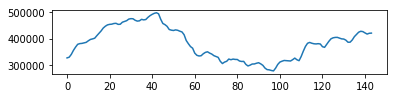

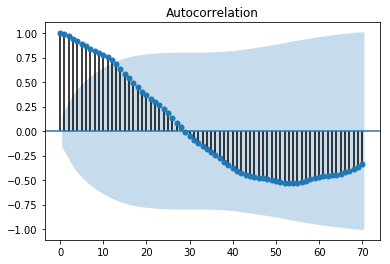

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


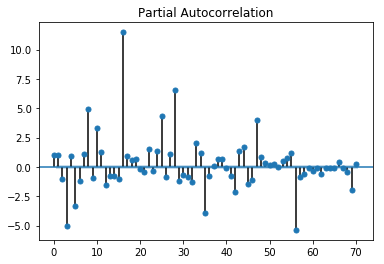

In [169]:
# draw plots
plt.subplot(3,1,1)
plt.plot(x) 
plt.show()
plot_acf(x, lags = 70) 
plt.show()
plot_pacf(x, lags = 70) 
plt.show()

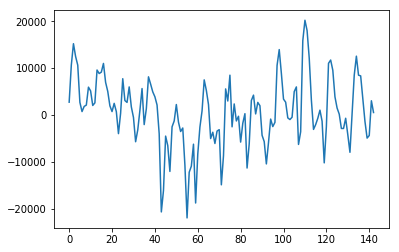

In [170]:
# try one time differencing
li_x = list(x)
d1 = list()
for i in range(1, len(li_x)):
    value = li_x[i] - li_x[i - 1]
    d1.append(float(value))
    
plt.plot(d1) 


In [171]:
# ADF TEST for d = 1

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


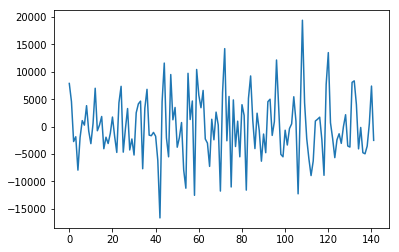

In [172]:
# two time differencing

d2 = list()
for i in range(1, len(d1)):
    value = d1[i] - d1[i - 1]
    d2.append(value)

plt.plot(d2)

In [173]:
# ADF for d = 2
adf_test(d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


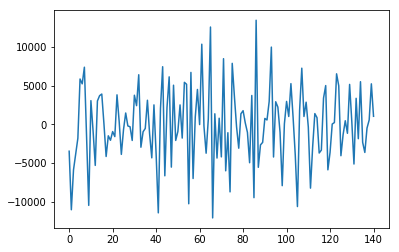

In [174]:
# differencing for seasonality
d3 = list()
for i in range(1, len(d2)):
    value = d2[i] - d2[i - 12]
    d3.append(value)

plt.plot(d3)

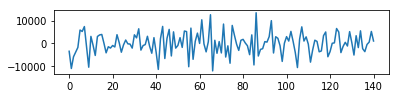

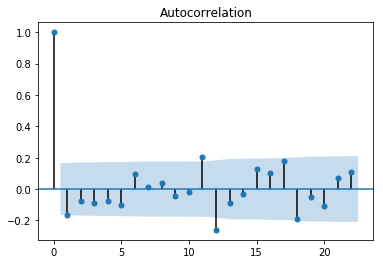

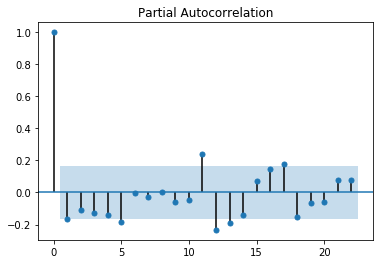

In [175]:
plt.subplot(3,1,1)
plt.plot(d3) 
plt.show()
plot_acf(np.array(d3)) 
plt.show()
plot_pacf(np.array(d3)) 
plt.show()

In [176]:
train_size = int(len(x) * 0.85)
train, test = df[15:train_size], df[train_size:]

In [177]:
train

,index,Median_Sold_Price,Median_Mortgage,Unemployment
15,15,420102.0,5.41,7.1
16,16,429251.4,5.28,7.0
17,17,440250.6,5.17,6.3
18,18,447225.0,5.28,6.9
19,19,452275.0,5.40,7.1
...,...,...,...,...
117,117,379850.0,4.04,6.4
118,118,380900.0,4.30,6.5
119,119,379600.0,4.47,6.7
120,120,369425.0,4.21,7.4


### Fit Univariate Model

In [178]:
# fit univariate model
model = pm.auto_arima(train['Median_Sold_Price'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1849.925, BIC=1862.588, Fit time=0.655 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1856.205, BIC=1861.270, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1859.688, BIC=1869.818, Fit time=0.146 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1859.671, BIC=1869.802, Fit time=0.135 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1852.810, BIC=1868.006, Fit time=0.640 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1848.793, BIC=1858.924, Fit time=0.127 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1858.493, BIC=1866.091, Fit time=0.031 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1850.749, BIC=1863.412, Fit time=0.255 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1858.486, BIC=1866.084, Fit time=0.056 seconds
Fit ARIMA: order=(1, 2, 2) s

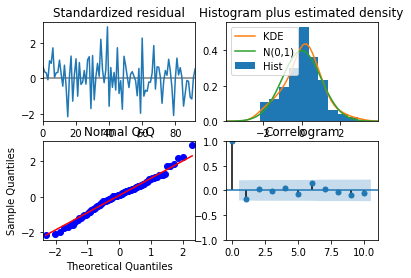

In [179]:
model.plot_diagnostics()
plt.show()

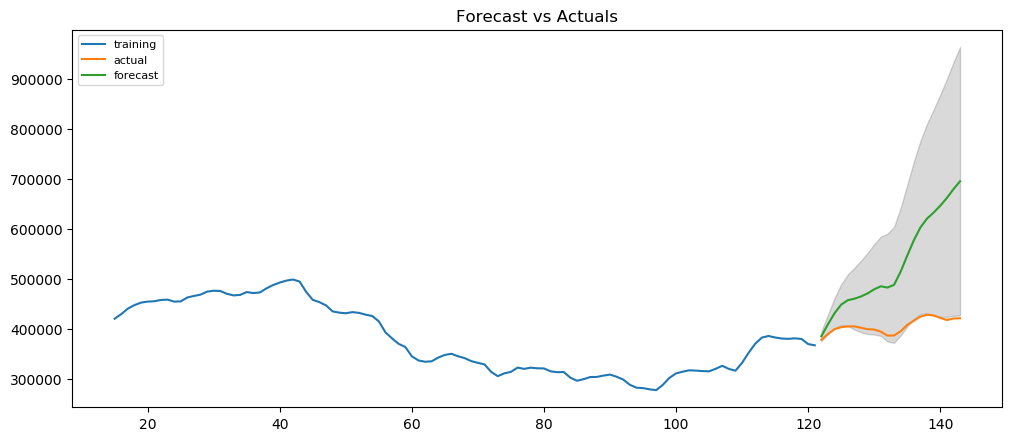

In [180]:
fitted = model.fit(train['Median_Sold_Price'])
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [181]:
n_periods = len(test)
model.predict(n_periods=n_periods)

array([385200.08843847, 408857.6738414 , 431166.83066669, 448304.08851075,
       457092.49616462, 460093.20583697, 464523.99677646, 470654.29136268,
       478816.31972917, 484902.16824156, 482361.50814814, 487749.84765852,
       514077.27526577, 546014.65625853, 576797.18197388, 602594.54598517,
       620224.53640858, 632244.25709011, 645868.37185305, 661363.90559528,
       679061.24346361, 694851.05201052])

In [182]:
mse = ((fc_series - test['Median_Sold_Price']) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

146818.44


In [188]:
model = ExponentialSmoothing(train['Median_Sold_Price'], trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train['Median_Sold_Price'], trend="add", seasonal="mul", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [189]:
test

,index,Median_Sold_Price,Median_Mortgage,Unemployment
122,122,377975.0,4.30,7.4
123,123,389700.0,4.21,7.3
124,124,399250.0,4.05,7.2
125,125,403150.0,4.07,6.7
126,126,404650.0,4.13,7.3
127,127,404850.0,4.06,7.5
128,128,402000.0,4.19,6.3
129,129,399150.0,4.03,6.0
130,130,398475.0,3.90,6.2
131,131,394275.0,3.85,6.2


In [193]:
pred.index = [i for i in range(122,144)]
pred2.index = [i for i in range(122,144)]

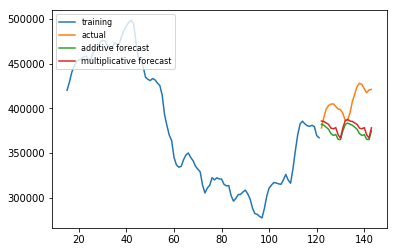

In [194]:
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [195]:
rmse1 = np.sqrt(np.mean(np.square(test['Median_Sold_Price'] - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test['Median_Sold_Price'] - pred2.values)))
print(rmse1)
print(rmse2)

36157.41043402741
31763.36355032149


### Test multivariate case

In [201]:
unemployment = df['Unemployment']
exog_train = unemployment[15:train_size,]
exog_test = unemployment[train_size:,]

In [211]:
len(exog_test)

22

In [212]:
modelx = SARIMAX(train['Median_Sold_Price'].values, order=(1,2,1),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1061.801
Date:                Sat, 07 Dec 2019   AIC                           2131.603
Time:                        21:48:45   BIC                           2142.218
Sample:                             0   HQIC                          2135.904
                                - 107                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment  -564.8822    791.424     -0.714      0.475   -2116.045     986.280
ar.L1            0.9172      0.057     16.212      0.000       0.806       1.028
ma.L1           -0.9944      0.101     -9.89

In [215]:
fc = fitx.predict(start=len(exog_train), end=len(exog_train)+ len(exog_test) - 1, exog=np.array(exog_test).reshape(22,1))


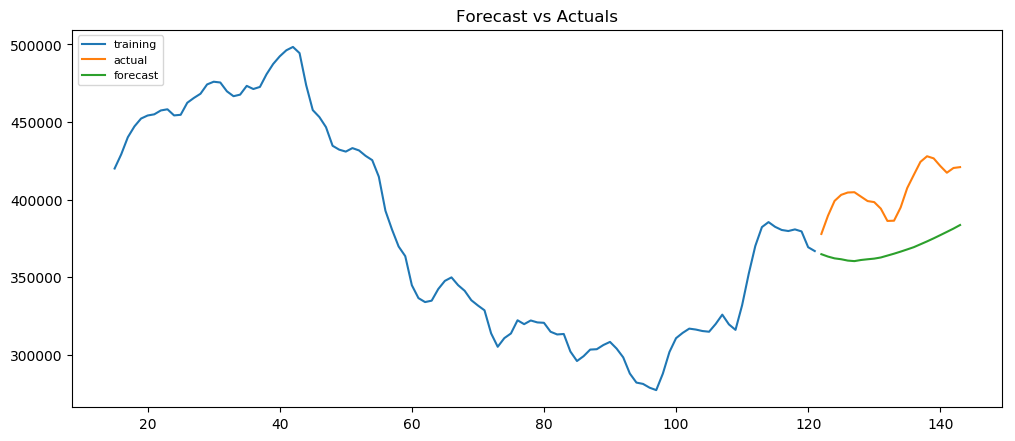

In [216]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [217]:
mse = ((fc_series - test['Median_Sold_Price']) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

39047.19


### Multivariate with Mortgage

In [218]:
series = df[['Unemployment', 'Median_Mortgage','Median_Sold_Price']]
train = series[:train_size]
test = series[train_size:]
train

,Unemployment,Median_Mortgage,Median_Sold_Price
0,7.9,5.02,326752.55
1,7.8,4.94,329501.50
2,7.8,4.74,340125.45
3,7.5,5.16,355329.50
4,7.3,5.64,367818.15
...,...,...,...
117,6.4,4.04,379850.00
118,6.5,4.30,380900.00
119,6.7,4.47,379600.00
120,7.4,4.21,369425.00


In [219]:
Mortgage = series['Median_Mortgage']
exog_train = Mortgage[:train_size,]
exog_test = Mortgage[train_size:,]

In [220]:
modelx = SARIMAX(train['Median_Sold_Price'], order=(1,2,1), exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:      Median_Sold_Price   No. Observations:                  122
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1206.060
Date:                Sat, 07 Dec 2019   AIC                           2420.119
Time:                        21:50:06   BIC                           2431.269
Sample:                             0   HQIC                          2424.647
                                - 122                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Median_Mortgage  3901.1619   2479.800      1.573      0.116    -959.157    8761.481
ar.L1               0.8239      0.084      9.862      0.000       0.660       0.988
ma.L1              -0.9437      

In [221]:
train_size

122

In [225]:
fc = fitx.predict(start=len(exog_train), end=len(exog_train) + len(exog_test) - 1, exog=np.array(exog_test).reshape(22,1))



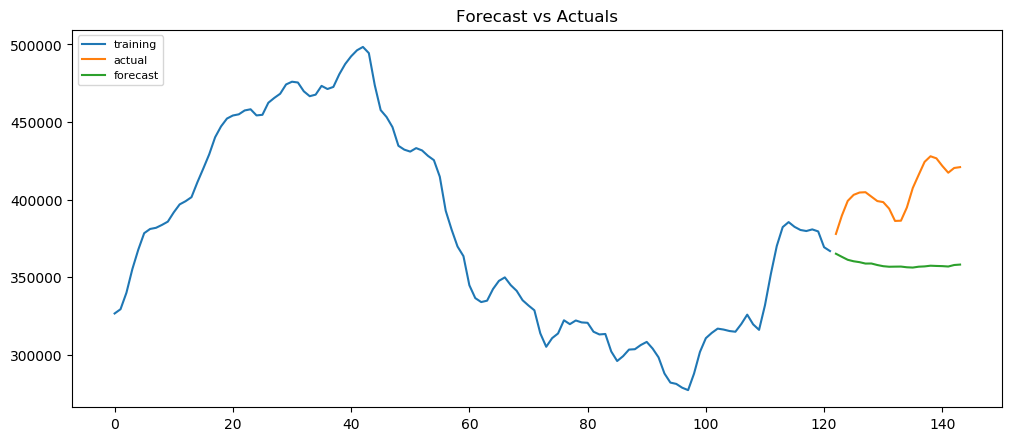

In [226]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [227]:
mse = ((fc_series - test['Median_Sold_Price']) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

49638.81


### VAR

In [228]:
series = df[['Median_Mortgage', 'Median_Sold_Price']]
train = series[:int(0.75*(len(series)))]
test = series[int(0.75*(len(series))):]
train.head()

,Median_Mortgage,Median_Sold_Price
0,5.02,326752.55
1,4.94,329501.50
2,4.74,340125.45
3,5.16,355329.50
4,5.64,367818.15


In [229]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     21:50:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8614
Nobs:                     106.000    HQIC:                   13.7120
Log likelihood:          -1012.15    FPE:                    814493.
AIC:                      13.6102    Det(Omega_mle):         742768.
--------------------------------------------------------------------
Results for equation Median_Mortgage
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.008297         0.101535            0.082           0.935
L1.Median_Mortgage           1.064999         0.102196           10.421           0.000
L1.Median_Sold_Price  

In [261]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = series.columns
pred = pd.DataFrame(index=test.index,columns=[cols])
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]
    

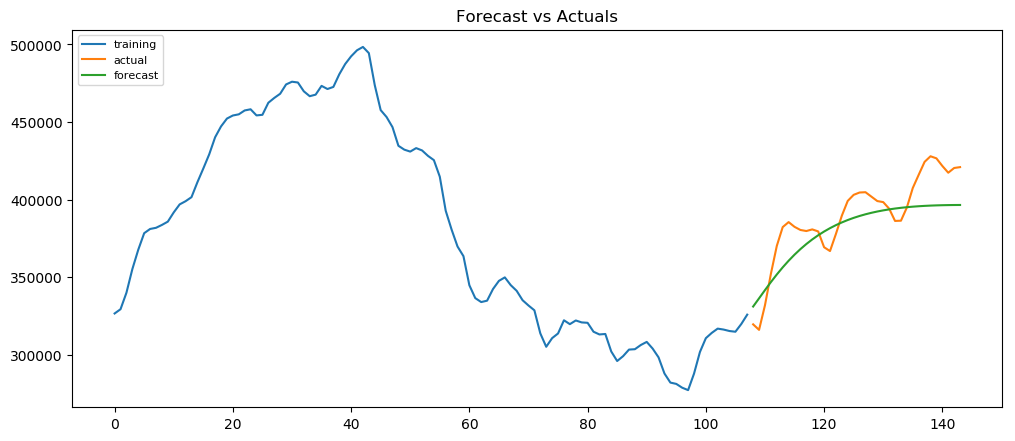

In [262]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Median_Sold_Price, label='training')
plt.plot(test.Median_Sold_Price, label='actual')
plt.plot(pred.iloc[:,1], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [280]:
mse_mu = ((pd.DataFrame(fc).iloc[:,1].values - test['Median_Sold_Price'].values) ** 2).mean()
rmse_mu = round(np.sqrt(mse_mu), 2)
print(rmse_mu)

16579.9


### Test multivariate (Mortgage and Unemployment Rates)

In [232]:
train_size = int(len(x) * 0.85)
train, test = df[0:train_size], df[train_size:]

In [233]:
mort_un = df[['Unemployment', 'Median_Mortgage']].values
mu_exog_train = mort_un[:train_size, :]
mu_exog_test = mort_un[train_size:, :]

In [234]:
model_mu = SARIMAX(train['Median_Sold_Price'], order=(1,2,1),exog=mu_exog_train)
fit_mu =model_mu.fit()
print(fit_mu.summary())

                           Statespace Model Results                           
Dep. Variable:      Median_Sold_Price   No. Observations:                  122
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1205.622
Date:                Sat, 07 Dec 2019   AIC                           2421.245
Time:                        21:50:43   BIC                           2435.182
Sample:                             0   HQIC                          2426.905
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -620.0286    677.908     -0.915      0.360   -1948.704     708.647
x2          3845.3873   2564.603      1.499      0.134   -1181.141    8871.916
ar.L1          0.8264      0.083      9.942      0.0

In [235]:
fc_mu = fit_mu.predict(start=train_size, end=train_size + len(mu_exog_test) - 1, exog=mu_exog_test)

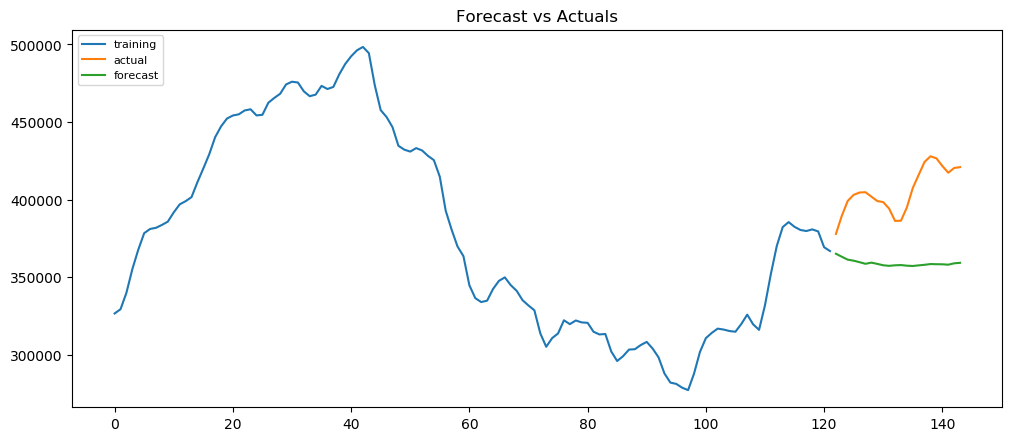

In [236]:
fc_mu_series = pd.Series(fc_mu)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_mu_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [237]:
mse_mu = ((fc_mu_series - test['Median_Sold_Price']) ** 2).mean()
rmse_mu = round(np.sqrt(mse_mu), 2)
print(rmse_mu)

48890.87


In [238]:
# VAR

In [239]:
series_mu = df[['Unemployment','Median_Mortgage', 'Median_Sold_Price']]
train = series_mu[:int(0.75*(len(series_mu)))]
test = series_mu[int(0.75*(len(series_mu))):]
train.head()

,Unemployment,Median_Mortgage,Median_Sold_Price
0,7.9,5.02,326752.55
1,7.8,4.94,329501.50
2,7.8,4.74,340125.45
3,7.5,5.16,355329.50
4,7.3,5.64,367818.15


In [240]:
model_mu_var = VAR(endog=train)
model_mu_var = model_mu_var.fit(2)
print(model_mu_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     21:50:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9060
Nobs:                     106.000    HQIC:                   12.5922
Log likelihood:          -1086.28    FPE:                    237744.
AIC:                      12.3784    Det(Omega_mle):         196242.
--------------------------------------------------------------------
Results for equation Unemployment
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        4.153300         0.976701            4.252           0.000
L1.Unemployment              0.628642         0.100424            6.260           0.000
L1.Median_Mortgage       

In [241]:
fc_mu_var = model_mu_var.forecast(model_mu_var.y, steps=len(test))
cols_mu = series_mu.columns
pred_mu = pd.DataFrame(index=test.index, columns=[cols_mu])
for j in range(0,3):
    for i in range(0, len(fc_mu_var)):
        pred_mu.iloc[i][j] = fc_mu_var[i][j]

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


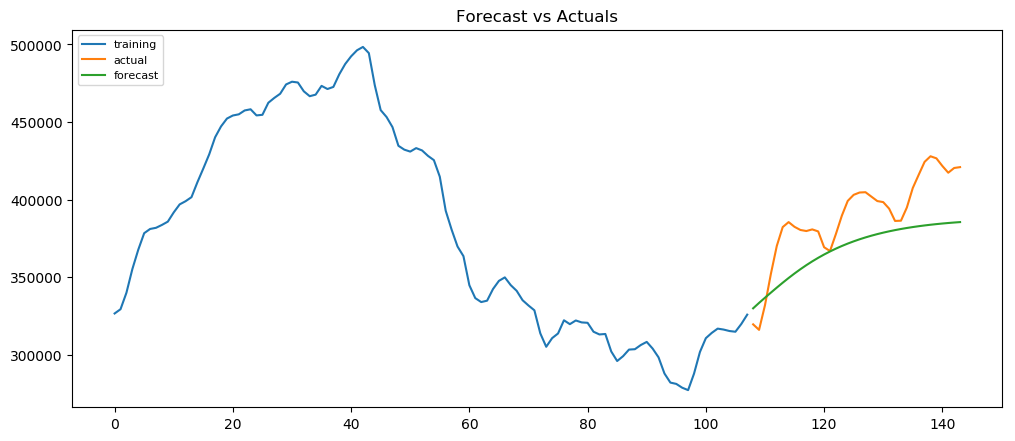

In [242]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Median_Sold_Price, label='training')
plt.plot(test.Median_Sold_Price, label='actual')
plt.plot(pred_mu.iloc[:,2], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [259]:
fc = pd.DataFrame(fc_mu_var).iloc[:,2]
mse_mu = ((fc.iloc[0] - test['Median_Sold_Price']) ** 2).mean()
rmse_mu = round(np.sqrt(mse_mu), 2)
print(rmse_mu)

65413.9


In [243]:
model_mu_var1 = VAR(endog=train)
model_mu_var1 = model_mu_var1.fit(1)
print(model_mu_var1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     21:50:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.1529
Nobs:                     107.000    HQIC:                   12.9746
Log likelihood:          -1131.12    FPE:                    382013.
AIC:                      12.8531    Det(Omega_mle):         342185.
--------------------------------------------------------------------
Results for equation Unemployment
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        3.911174         0.839122            4.661           0.000
L1.Unemployment              0.623112         0.074562            8.357           0.000
L1.Median_Mortgage       

In [244]:
fc_mu_var1 = model_mu_var1.forecast(model_mu_var1.y, steps=len(test))
cols_mu = series_mu.columns
pred_mu1 = pd.DataFrame(index=test.index, columns=[cols_mu])
for j in range(0,3):
    for i in range(0, len(fc_mu_var1)):
        pred_mu1.iloc[i][j] = fc_mu_var1[i][j]

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


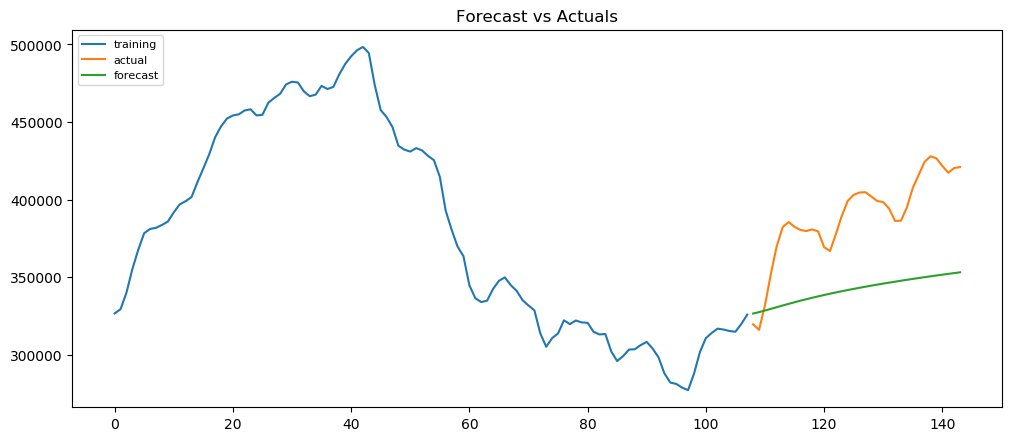

In [245]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Median_Sold_Price, label='training')
plt.plot(test.Median_Sold_Price, label='actual')
plt.plot(pred_mu1.iloc[:,2], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [257]:
fc = pd.DataFrame(fc_mu_var1).iloc[:,2]

In [256]:
mse_mu = ((fc.iloc[0] - test['Median_Sold_Price']) ** 2).mean()
rmse_mu = round(np.sqrt(mse_mu), 2)
print(rmse_mu)

68484.92
